# TM10007 Assignment template

In [17]:
# Run this to use from colab environment
#!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [2]:
# Data loading functions. Uncomment the one you want to use
#from worcgist.load_data import load_data
#from worclipo.load_data import load_data
#from worcliver.load_data import load_data
#from ecg.load_data import load_data
# General packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets as ds
import seaborn as sns
import os

# Classifiers
from sklearn import model_selection
from sklearn import metrics
from sklearn import feature_selection
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import svm
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR

def load_data():
    this_directory = os.getcwd()
    data = pd.read_csv(os.path.join(this_directory, 'Lipo_radiomicFeatures.csv'), index_col=0)
    return data

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')



The number of samples: 115
The number of columns: 494


In [3]:
# Load the dataset
file_path = "data.csv"  # Ensure the dataset is in the same directory as the notebook
df = pd.read_csv(file_path)

# Display basic info and first few rows
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Columns: 495 entries, ID to PREDICT_original_phasef_phasesym_entropy_WL3_N5
dtypes: float64(468), int64(25), object(2)
memory usage: 444.9+ KB


,ID,label,PREDICT_original_sf_compactness_avg_2.5D,PREDICT_original_sf_compactness_std_2.5D,PREDICT_original_sf_rad_dist_avg_2.5D,PREDICT_original_sf_rad_dist_std_2.5D,PREDICT_original_sf_roughness_avg_2.5D,PREDICT_original_sf_roughness_std_2.5D,PREDICT_original_sf_convexity_avg_2.5D,PREDICT_original_sf_convexity_std_2.5D,...,PREDICT_original_phasef_phasesym_median_WL3_N5,PREDICT_original_phasef_phasesym_std_WL3_N5,PREDICT_original_phasef_phasesym_skewness_WL3_N5,PREDICT_original_phasef_phasesym_kurtosis_WL3_N5,PREDICT_original_phasef_phasesym_peak_WL3_N5,PREDICT_original_phasef_phasesym_peak_position_WL3_N5,PREDICT_original_phasef_phasesym_range_WL3_N5,PREDICT_original_phasef_phasesym_energy_WL3_N5,PREDICT_original_phasef_phasesym_quartile_range_WL3_N5,PREDICT_original_phasef_phasesym_entropy_WL3_N5
0,Lipo-001_0,liposarcoma,0.368434,0.262371,26.200395,8.174390,20.940000,13.551937,0.694139,0.227848,...,0.049726,0.196019,0.927821,-0.407270,0.0,0,0.625304,3238.304991,0.315148,14.462361
1,Lipo-002_0,liposarcoma,0.660571,0.179013,55.155046,9.318741,9.546044,7.051937,0.871182,0.125279,...,0.036186,0.167471,1.137972,0.411968,0.0,0,0.563659,15364.724390,0.251255,17.170274
2,Lipo-003_0,lipoma,0.365191,0.157712,30.577026,8.963647,17.695139,10.772365,0.704710,0.137529,...,0.128167,0.220546,0.829650,-0.520344,0.0,0,0.705679,3771.798158,0.369366,14.394812
3,Lipo-004_0,liposarcoma,0.372210,0.169761,94.006805,33.512409,21.049148,15.928362,0.754497,0.186559,...,0.000000,0.107987,3.130011,10.399652,0.0,0,0.438399,4707.658397,0.000000,15.733482
4,Lipo-005_0,lipoma,0.369120,0.167485,94.612701,31.250821,17.059573,15.239905,0.774545,0.192922,...,0.000000,0.087662,3.284943,11.840826,0.0,0,0.356330,6171.440113,0.000000,16.682154


In [4]:
# Check for missing values
missing_values = df.isnull().sum().sum()
print(f"Total missing values: {missing_values}")

# Encode the target variable
df['label'] = df['label'].map({'lipoma': 0, 'liposarcoma': 1})

# Drop ID column as it is not useful for training
df.drop(columns=['ID'], inplace=True)

# Normalize numerical features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df.iloc[:, 1:] = scaler.fit_transform(df.iloc[:, 1:])

# Display dataset after preprocessing
df.head()

Total missing values: 0


C:\Users\Kaspe\AppData\Local\Temp\ipykernel_13776\3430236790.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.65205945  0.31068168  1.16645157 -1.61480058  0.73856663 -0.86600192
  0.9525091   0.09673921 -0.75903069 -0.01023203  0.41765292  1.05948034
  1.16645157  0.84553786  0.84553786 -1.40085811 -0.54508821 -0.01023203
  0.73856663 -0.43811698  0.9525091   0.63159539  0.9525091   0.52462415
  0.63159539  0.63159539 -0.2241745   0.52462415 -0.33114574 -1.93571429
  1.05948034 -0.65205945  0.52462415 -2.04268553 -2.68451295 -0.33114574
  0.84553786  0.73856663  0.09673921  0.73856663 -0.75903069  0.20371044
 -2.256628   -0.01023203  0.84553786  0.20371044  0.73856663 -1.40085811
  0.9525091  -1.72177182  0.20371044 -0.01023203 -0.43811698  0.31068168
 -1.50782934  0.41765292 -1.50782934  0.52462415 -1.72177182  0.20371044
  0.73856663  1.59433652  1.05948034  0.09673921 -1.0799444   1.16645157
 -0.6520594

,label,PREDICT_original_sf_compactness_avg_2.5D,PREDICT_original_sf_compactness_std_2.5D,PREDICT_original_sf_rad_dist_avg_2.5D,PREDICT_original_sf_rad_dist_std_2.5D,PREDICT_original_sf_roughness_avg_2.5D,PREDICT_original_sf_roughness_std_2.5D,PREDICT_original_sf_convexity_avg_2.5D,PREDICT_original_sf_convexity_std_2.5D,PREDICT_original_sf_cvar_avg_2.5D,...,PREDICT_original_phasef_phasesym_median_WL3_N5,PREDICT_original_phasef_phasesym_std_WL3_N5,PREDICT_original_phasef_phasesym_skewness_WL3_N5,PREDICT_original_phasef_phasesym_kurtosis_WL3_N5,PREDICT_original_phasef_phasesym_peak_WL3_N5,PREDICT_original_phasef_phasesym_peak_position_WL3_N5,PREDICT_original_phasef_phasesym_range_WL3_N5,PREDICT_original_phasef_phasesym_energy_WL3_N5,PREDICT_original_phasef_phasesym_quartile_range_WL3_N5,PREDICT_original_phasef_phasesym_entropy_WL3_N5
0,1,-0.636358,1.178671,-0.892099,-0.591539,0.105944,-0.163109,-0.525603,0.864401,0.279704,...,0.473530,0.960241,-0.912616,-0.738021,0.0,0,0.776568,-0.388714,1.048810,-0.322777
1,1,0.868499,-0.001097,0.324289,-0.445390,-0.781146,-0.571225,0.569888,-0.328527,-1.144128,...,0.194855,0.283867,-0.648104,-0.546022,0.0,0,0.238135,1.207257,0.517048,1.221523
2,0,-0.653059,-0.302556,-0.708236,-0.490740,-0.146689,-0.337630,-0.460197,-0.186049,0.100405,...,2.087912,1.541353,-1.036182,-0.764522,0.0,0,1.478594,-0.318501,1.500051,-0.361300
3,1,-0.616905,-0.132029,1.956455,2.644459,0.114441,-0.013900,-0.152128,0.384195,0.873545,...,-0.549889,-1.125449,1.859232,1.794725,0.0,0,-0.855941,-0.195331,-1.574077,0.402132
4,0,-0.632823,-0.164240,1.981909,2.355624,-0.196172,-0.057127,-0.028077,0.458204,0.778158,...,-0.549889,-1.606982,2.054241,2.132483,0.0,0,-1.572767,-0.002681,-1.574077,0.943152


In [5]:
# Feature selection based on variance
variance_selector = VarianceThreshold(threshold=0.01)
data_var= variance_selector.fit_transform(data.iloc[:, 2:])

print(data_var)

print(f'The number of columns after variance selection: {(data_var.shape[1])}')
print(f'The number of rows after variance selection: {(data_var.shape[0])}')

[[2.62003946e+01 8.17438991e+00 2.09399999e+01 ... 3.23830499e+03
  3.15148298e-01 1.44623614e+01]
 [5.51550462e+01 9.31874053e+00 9.54604353e+00 ... 1.53647244e+04
  2.51255317e-01 1.71702745e+01]
 [3.05770259e+01 8.96364718e+00 1.76951389e+01 ... 3.77179816e+03
  3.69366254e-01 1.43948122e+01]
 ...
 [4.94737956e+01 1.65376653e+01 2.79338401e+01 ... 4.96797676e+03
  2.46028326e-01 1.51067769e+01]
 [3.85229179e+01 9.69848750e+00 1.38420147e+01 ... 2.34864119e+03
  1.61139764e-01 1.47716419e+01]
 [9.98527053e+01 1.46927655e+01 1.02222453e+01 ... 1.04654714e+04
  0.00000000e+00 1.75445559e+01]]
The number of columns after variance selection: 248
The number of rows after variance selection: 115


In [6]:
# Dimensionality Reduction with PCA
# Quick scaling, will be done in preprocessing earlier
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_var)

# Apply PCA based on them to explain 99% of the data
pca = decomposition.PCA(n_components=0.99)
data_pca = pca.fit_transform(data_scaled)

print(type(data))
print(f"Number of components after PCA: {data_pca.shape[1]}")

<class 'pandas.core.frame.DataFrame'>
Number of components after PCA: 68


[[-3.79417146e+00  2.69159619e+00 -4.74153911e+00 ... -2.95733066e-01
   2.57171824e-02 -2.79695750e-01]
 [ 4.73838529e+00  3.64219111e+00  6.11292062e-01 ... -5.73840494e-02
  -5.10715241e-01 -2.56427006e-01]
 [-3.58370778e+00 -6.02381514e+00  2.93238251e-01 ...  2.44733846e-01
  -1.89684416e-01  1.15982657e-01]
 ...
 [ 1.48232577e+01  4.67601242e+00  1.51708014e+00 ... -1.01415644e-02
   2.00925673e-01  3.79586983e-01]
 [-3.72848704e+00  5.04727952e-01 -3.62986167e-01 ...  9.79777126e-02
   3.17074945e-01  4.77415946e-01]
 [ 1.73277208e-01 -5.48470813e+00 -6.52107650e+00 ... -3.13059228e-01
   1.64304264e-01 -5.82882407e-01]]


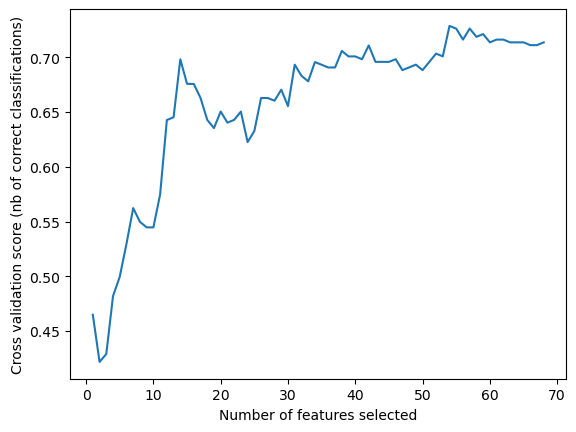

In [7]:
# Split into train and test
X = data_pca
y = data.iloc[:, 0].map({'liposarcoma': 1, 'lipoma': 0})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(X_train)

# Feature selection by RFE
svc = svm.SVC(kernel="linear")

# classifications
rfecv = feature_selection.RFECV(
    estimator=svc, step=1,
    cv=model_selection.StratifiedKFold(4),
    scoring='roc_auc')
rfecv.fit(X_train, y_train)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.cv_results_["mean_test_score"]) + 1), rfecv.cv_results_["mean_test_score"])
plt.show()

In [8]:
# Feature selection with Random Forest
randomforest =  RandomForestClassifier(n_estimators = 100, random_state=42)
randomforest.fit(X_train, y_train)

feature_importance = randomforest.feature_importances_

n_importance = 15
important_features = sorted(range(len(feature_importance)), key=lambda i: feature_importance[i], reverse=True)[:n_importance]

print(important_features)

print(f"Most important features (indices): {important_features}")
print(f"Feature importances: {feature_importance[important_features]}")

[1, 14, 59, 29, 6, 53, 60, 33, 64, 15, 3, 39, 62, 25, 58]
Most important features (indices): [1, 14, 59, 29, 6, 53, 60, 33, 64, 15, 3, 39, 62, 25, 58]
Feature importances: [0.04010429 0.03249132 0.02900754 0.02856263 0.02640269 0.02322392
 0.02307736 0.02288208 0.0224113  0.02184907 0.02025067 0.01951755
 0.01925546 0.01908927 0.01873543]
